In [1]:
using Distributions 
using IntervalSets
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Random123
using HCubature
using LaTeXStrings

In [2]:
import Plots
import PyPlot
Plots.pyplot()

plt = PyPlot

SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = vcat([0 0 0 0], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]);

In [3]:
using Revise
using BATPar
using KDTree
using BAT

# Density Function

In [ ]:
# # simple Normal Distribution: 

# N = 5
# min_v = -6.
# max_v = 6.

# lgV = N*log(max_v-min_v); 

# f(x::AbstractArray) = prod(pdf.(Normal(0, 1), x))

# LogTrueIntegral(N)=0.0

In [ ]:
# simple Normal Distribution: 

N = 5
min_v = -10.
max_v = 10.

dist_dim = truncated(Normal(0,1), min_v, max_v)
dist = product_distribution([dist_dim for i in 1:N])

f(x::AbstractArray) = pdf(dist, x)

lgV = N*log(max_v-min_v); 

LogTrueIntegral(N)=0.0

In [4]:
true_param =(μ1=2, μ2=-2, σ=0.13)

function f(x::AbstractArray; true_param=true_param)
    tmp = 1
    for i in eachindex(x)
        if i > 2
            tmp *= pdf(Cauchy(true_param.μ1 + true_param.μ2, true_param.σ), x[i])
        else 
            tmp *= 0.5*pdf(Cauchy(true_param.μ1, true_param.σ), x[i]) + 0.5*pdf(Cauchy(true_param.μ2, true_param.σ), x[i])
        end
    end
    return tmp
end

function LogTrueIntegral(N; max = max_v, min=min_v,  true_param=true_param) 
    tmp = 0
    for i in 1:N
        if i > 2
            tmp += log(cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), min_v))
        else 
            tmp += log(cdf(Cauchy(true_param.μ1,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 ,true_param.σ), min_v))
        end
    end
    return tmp
end

N = 6
min_v = -10.
max_v = 10.

lgV = N*log(max_v-min_v); 


# Serial Sampling

In [5]:
likelihood = params -> LogDVal((log(f(params.a))))
prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],)
posterior = PosteriorDensity(likelihood, prior);

In [6]:
nnsamples = 10^2
nnchains = 5

samples, stats = bat_sample(posterior, (nnsamples, nnchains), MetropolisHastings());

┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 5 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.

In [7]:
smpl = flatview(unshaped.(samples.v))
weights_LogLik = samples.logd
weights_Histogram = samples.weight;

data_kdtree = Data(smpl[:,1:end], weights_Histogram[1:end], weights_LogLik[1:end]);

# Space Partitioning: 

In [8]:
KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

output, cost_array = DefineKDTree(data_kdtree, collect(1:N), 10);

extend_tree_bounds!(output, repeat([min_v], N), repeat([max_v], N))

┌ Info: KDTree: Increasing tree depth: depth = 1
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 2
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 3
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 4
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 5
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 6
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 7
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 8
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: d

In [9]:
prior_bounds = [min_v, max_v] 

extend_tree_bounds!(output, repeat([prior_bounds[1]], N), repeat([prior_bounds[2]], N))

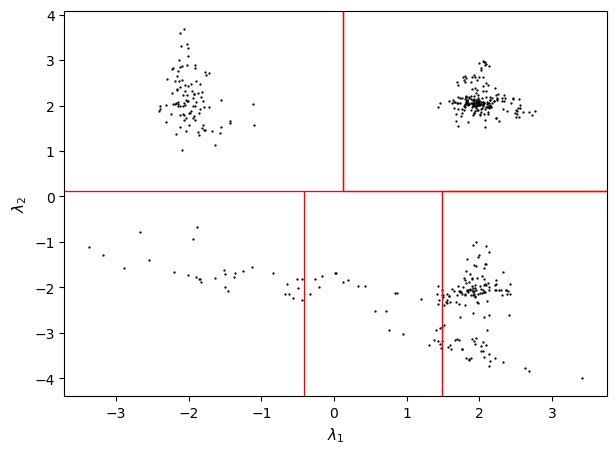

PyObject <matplotlib.patches.Rectangle object at 0x1621be210>

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.scatter(smpl[1,:], smpl[2,:], color="k", s=0.4)
ax.set_xlabel(L"\lambda_1")
ax.set_ylabel(L"\lambda_2")

plot_tree(output, [1,2], ax, color="red")

# ax.set_xlim(-11., 11.)
# ax.set_ylim(-11., 11.)

# ax.set_xlim(-4., 4.)
# ax.set_ylim(-4., 4.)

# Sampling of subspaces 

In [11]:
burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 5000,
    max_nsteps_per_cycle = 50000,
    max_time_per_cycle = Inf,
    max_ncycles = 150
)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.05..0.15,
    β = 1.5,
    c = 1e-4..1e2
)


AHMI_settingss = BAT.HMISettings(BAT.cholesky_partial_whitening!,
    10000, 2.5, 0.1, true, 16, true, Dict("cov. weighted result" => BAT.hm_combineresults_covweighted!)
)

algorithm = MetropolisHastings(ARPWeighting())

nnchains = 10
nnsamples = 10^4;

In [12]:
bounds_part = extract_par_bounds(output)
BATPar.make_named_prior(i) = BAT.NamedTupleDist( a =  [[i[j,1]..i[j,2] for j in 1:size(i)[1]]...])
algorithm = MetropolisHastings();

samples_parallel = bat_sample_parallel(likelihood, bounds_part, (nnsamples, nnchains), algorithm, tuning=tuning, burnin=burnin, settings=AHMI_settingss); 

┌ Info: BATPar: Sampling subspace 1:
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:82
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 3 tuned, 10 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 fini

In [13]:
smpl_par = hcat(samples_parallel.samples...)
x = smpl_par[1,:]
y = smpl_par[2,:]
w_o = samples_parallel.weights_o
w_r =  samples_parallel.weights_r;

In [14]:
@show "Truth", exp(LogTrueIntegral(N))

@show "Int", sum(samples_parallel.integrals), sqrt(sum((samples_parallel.uncertainty).^2));

("Truth", exp(LogTrueIntegral(N))) = ("Truth", 0.9507012208933535)
("Int", sum(samples_parallel.integrals), sqrt(sum(samples_parallel.uncertainty .^ 2))) = ("Int", 0.9339005565659393, 0.005193825849973049)


In [15]:
# bin_range = range(min_v, stop=max_v, length=50)

histogram_wr = fit(Histogram, (x, y), weights(w_r), nbins=100)
histogram_wo = fit(Histogram, (x, y), weights(w_o), nbins=100)
histogram_wr = normalize(histogram_wr, mode=:pdf);
histogram_wo = normalize(histogram_wo, mode=:pdf);

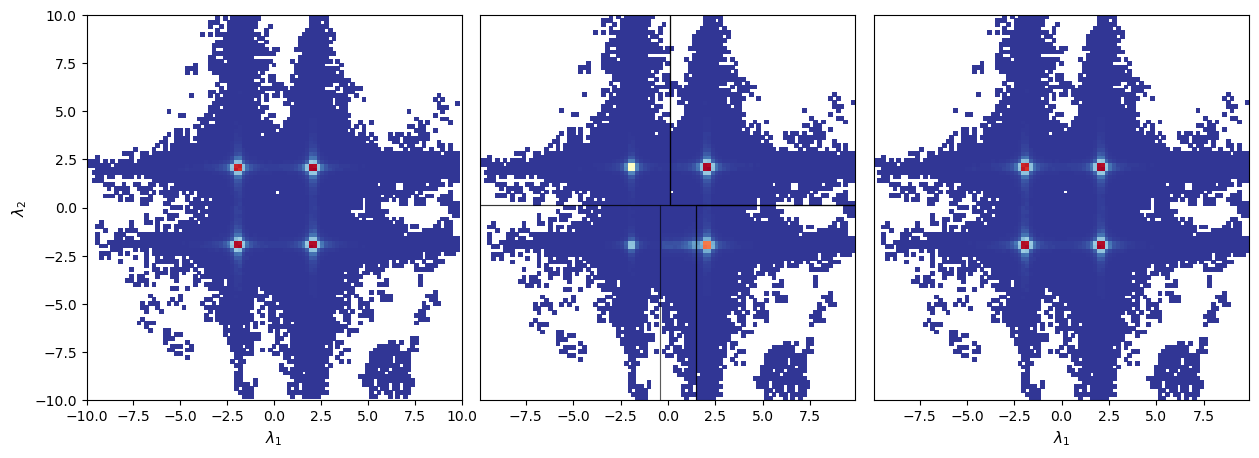

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.05)

ax[1].pcolormesh(midpoints(histogram_wr.edges[1]), midpoints(histogram_wr.edges[2]), replace(histogram_wr.weights', 0=>NaN), cmap="RdYlBu_r") 
ax[3].pcolormesh(midpoints(histogram_wr.edges[1]), midpoints(histogram_wr.edges[2]), replace(histogram_wr.weights', 0=>NaN), cmap="RdYlBu_r") 
ax[2].pcolormesh(midpoints(histogram_wo.edges[1]), midpoints(histogram_wo.edges[2]), replace(histogram_wo.weights', 0=>NaN), cmap="RdYlBu_r") 

plot_tree(output, [1,2], ax[2], linewidth=0.8, color="black", alpha=0.4)

ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

ax[1].set_xlim(min_v, max_v)
ax[1].set_ylim(min_v, max_v)

ax[3].set_xlabel(L"\lambda_1")
ax[3].get_yaxis().set_visible(false)
ax[2].get_yaxis().set_visible(false)

# Underestimation/bias 

In [30]:
n_cuts = 2
n_smpl_cut = 10^5
n_chains = 10

AHMI_settings = BAT.HMISettings(BAT.cholesky_partial_whitening!,
    1000, 1.0, 0.1, true, 16, true, Dict("cov. weighted result" => BAT.hm_combineresults_covweighted!)
)

algorithm = MetropolisHastings()

burnin = BAT.MCMCBurninStrategy()

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.2,
    β = 1.5,
    c = 1e-4..1e2
)


AdaptiveMetropolisTuning
  λ: Float64 0.5
  α: Interval{:closed,:closed,Float64}
  β: Float64 1.5
  c: Interval{:closed,:closed,Float64}
  r: Float64 0.5


In [31]:
function generate_data(n_runs, n_cuts, n_smpl_cut, n_chains; AHMI_settings=AHMI_settings)
    
    integrals_true = Vector{Float64}()
    log_v_true = Vector{Float64}()
    
    integrals_partsmpl = Vector{Float64}()
    uns_partsmpl = Vector{Float64}()
    log_v_part = Vector{Float64}()
    
    integrals_ahmi = Vector{Float64}()
    uns_ahmi = Vector{Float64}()
    
    for i in 1:n_runs
        
        @show i 
        
        truth = exp(LogTrueIntegral(N))
        
        seeds, stats = bat_sample(posterior, (100, 10), MetropolisHastings())
        kd_data = Data(flatview(unshaped.(seeds.v))[:,1:end], seeds.weight[1:end], seeds.logd[1:end])
        kd_output, _ = DefineKDTree(kd_data, collect(1:N), n_cuts);
        extend_tree_bounds!(kd_output, repeat([min_v], N), repeat([max_v], N)) # try changing this 
        kd_bounds = extract_par_bounds(kd_output)
        samples_par = bat_sample_parallel(likelihood, kd_bounds, (n_smpl_cut, n_chains), algorithm, tuning=tuning, burnin=burnin, settings=AHMI_settings);
        par_integral_run = [sum(samples_par.integrals), sqrt(sum((samples_par.uncertainty).^2))] ./ truth
        
        tot_volum = sum([prod(diff(j, dims=2)) for j in kd_bounds])
        
        # ***
        
#         samples_serial, stats_serial = bat_sample(posterior, ((1+n_cuts)*n_smpl_cut, n_chains), MetropolisHastings(), tuning=tuning, burnin=burnin,)
#         hmi_data = BAT.HMIData(unshaped.(samples_serial))
#         BAT.hm_integrate!(hmi_data, settings=AHMI_settings)
        
#         ahmi_integral_run =[hmi_data.integralestimates["cov. weighted result"].final.estimate, hmi_data.integralestimates["cov. weighted result"].final.uncertainty]
		
        log_smpl_int = [0., 0.] #(ahmi_integral_run .* exp(lgV))/truth
        
        # ***
        
        push!(integrals_true, truth)
        push!(integrals_partsmpl, par_integral_run[1])
        push!(uns_partsmpl, par_integral_run[2])
        push!(integrals_ahmi, log_smpl_int[1])
        push!(uns_ahmi, log_smpl_int[2])
        push!(log_v_true, lgV)
        push!(log_v_part, tot_volum)
    end
    
    return (integrals_true, log_v_true, integrals_partsmpl, uns_partsmpl, log_v_part, integrals_ahmi, uns_ahmi)
end

generate_data (generic function with 1 method)

In [32]:
(int_true, lgV_true, int_part, uns_part, lgV_part, int_ahmi, uns_ahmi) = generate_data(10, n_cuts, n_smpl_cut, n_chains)

i = 1


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 2


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 3


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 4


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 3 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 5


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 2 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 6


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 7


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 8


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 9


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

i = 10


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 10 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc

([0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535, 0.9507012208933535], [17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946, 17.974393641323946], [0.9957606954854732, 0.9897969479773204, 1.0010821786444746, 0.9905609920313965, 0.9890814761651117, 0.9837304363993132, 1.00690583336742, 0.9826377514183836, 1.0189054070125478, 0.9908121427412743], [0.004454248650305629, 0.0033021619377482728, 0.005034482511315857, 0.005659232786638101, 0.004913787146233892, 0.004349212867693977, 0.003866255311872479, 0.004179635750343222, 0.0047950695869462805, 0.003936425459277471], [6.400000000000001e7, 6.4e7, 6.4e7, 6.4e7, 6.399999999999999e7, 6.4e7, 6.4e7, 6.399999999999999e7, 6.400000000000001e7, 6.4e7], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [33]:
integrals_partition = int_part
integral_ahmi = int_ahmi
integrals_true = ones(length(integral_ahmi))

unsert_partition = uns_part
unsert_ahmi = uns_ahmi;

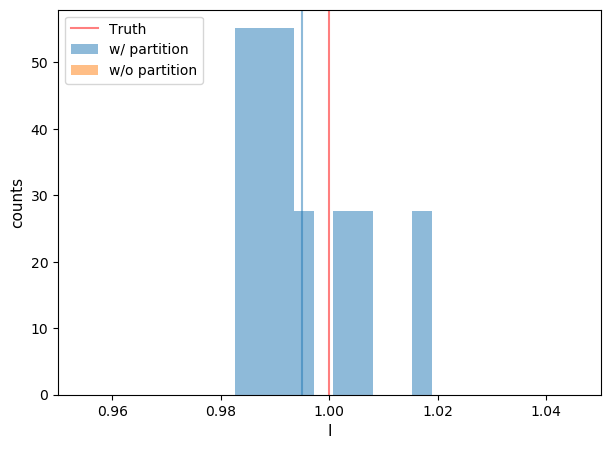

PyObject Text(25.000000000000007, 0.5, 'counts')

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.axvline(1, c="red", label="Truth", alpha=0.5)
ax.axvline(mean(integrals_partition), c="C0", alpha=0.5)
ax.axvline(mean(integral_ahmi), c="C1", alpha=0.5)

ax.hist(integrals_partition, bins=10, density=true, color="C0", alpha=0.5, label="w/ partition")
ax.hist(integral_ahmi, bins=10, density=true, color="C1", alpha=0.5, label="w/o partition")

ax.legend(loc="upper left", frameon=true, framealpha=0.8, ncol=1)

ax.set_xlim(0.95, 1.05)

ax.set_xlabel("I")
ax.set_ylabel("counts")

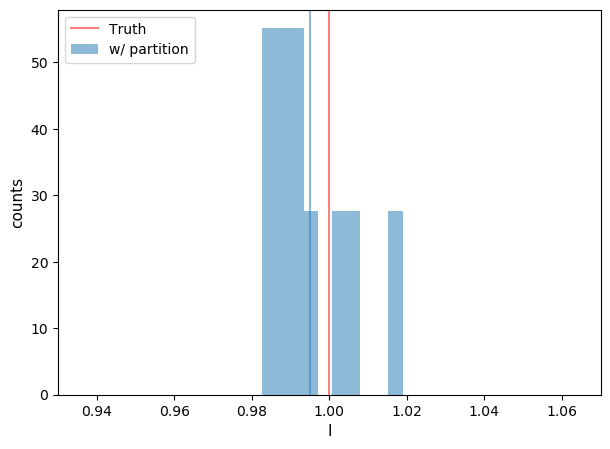

PyObject Text(25.000000000000007, 0.5, 'counts')

In [35]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.axvline(1, c="red", label="Truth", alpha=0.5)
ax.axvline(mean(integrals_partition), c="C0", alpha=0.5)

ax.hist(integrals_partition, bins=10, density=true, color="C0", alpha=0.5, label="w/ partition")
ax.legend(loc="upper left", frameon=true, framealpha=0.8, ncol=1)

ax.set_xlim(0.93, 1.07)

ax.set_xlabel("I")
ax.set_ylabel("counts")